# D213 Task 1 Time-Series Modeling
Vincent Taylor

### Part I

***A1 Research Question:***

The research question I chosed for this PA is "*Can we predict future daily revenue for the organization based on historical data?*" I believe that by exploring this research question will provide value to the organization by being able to use time-series modeling we can create actionable insights that we can use to further help strategic decsion making by ELT members. We also can use revenue estimates in order to identify an optimal time to increase or decrease headcount, or in terms of identifying when to promote a current employee. By building a strong model it will further solidfy our telecom company's position in the industry while also creating a more data-driven approach.


***A2 Goals of the analysis:***

The primary goal I have in this analysis is to build a model that can accurately forecast future expected revenue for the company.

### Part II

***B1 Summarize Assumptions:***

1. Autocorrelation
2. Seasonality
3. Stationarity


***Autocorrelation***: This assumption in a time series is linearly related to a lagged version of itself, essentially this means that the current value of the series is related to a preceding value of itself.

***Seasonality***: This assumption means that the data will have predictable changes that will happen around the same time evey year.

***Stationarity***: Stationary data refers to the idea that the mean and variance do not vary over time. This means that both of these measures should be constant over all time periods and that the trend remains stable.


### Part III

---

In [1]:
# import libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

df = pd.read_csv('teleco_time_series .csv', index_col='Day', parse_dates=True)
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [2]:
df.tail()

,Revenue
Day,
727,16.931559
728,17.490666
729,16.803638
730,16.194813
731,16.620798


### C1 visualizing the dataset:

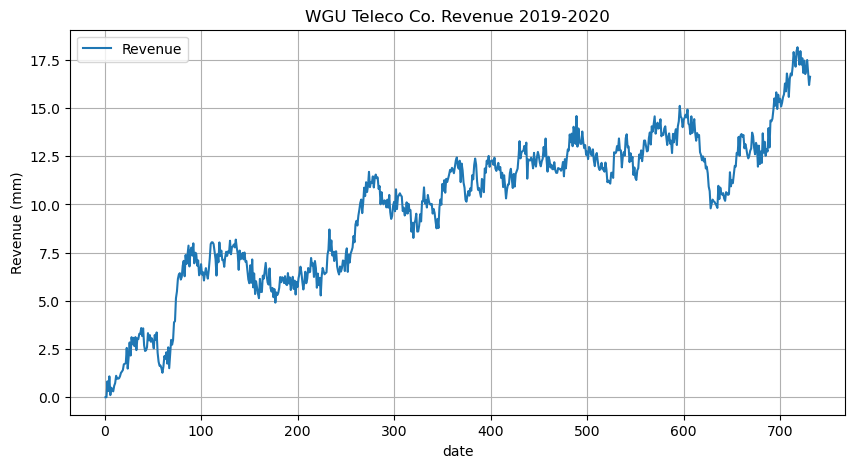

In [3]:
# plotting the graph
df.plot(grid=True, figsize=(10,5))
plt.title('WGU Teleco Co. Revenue 2019-2020')
plt.xlabel('date')
plt.ylabel('Revenue (mm)')
plt.show()

### C2 describe Gaps in measurment:

In [4]:
# Checking for null values
df.isnull().sum()

Revenue    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
# changing column names
df.columns=['revenue']

In [7]:
# statstical values of data
df.describe()

,revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


### (C3) Evaluating Stationarity:

A lack of stationarity is shown by the graph, which shows a noticeable upward trend in the data. However, in order to provide statistical support for this observation, I plan to perform an Augmented Dickey-Fuller (ADF) test in order to formally evaluate the dataset's stationarity. This will make it possible to analyze the temporal characteristics in a more detailed and reliable manner, which will increase the validity of our conclusions.



In [8]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

# performing ADF test
test_result = adfuller(df)

# results
def check_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', test_result[0])
    print('p-value:', test_result[1])
    print('Critical Values:', test_result[4])

check_stationarity(df['revenue'])

ADF Statistic: -1.924612157310183
p-value: 0.3205728150793967
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


### C3 Cont: 

I used an ADF test in order to support my prior claim that the data does not exhibit stationarity. ADF tests are often used to evaluate a time series' stationarity. The p-value of 0.3206 that was calculated is higher than the standard significance level of 0.05, which indicates that there is not enough evidence to reject the null hypothesis. Moreover, the ADF statistic is also another reason to reject the null hypothesis, and the more negative the number the stronger the rejection. To conclude we will accept the null hypothesis.

### Data Preperation Steps (C4)

1. Import CSV
2. Changing the Days to YYYY/MM/DD Format.
3. Visualize the data in a time series format.
4. Check to see if the data in the Revenue column is stationary.
5. Transform Revenue column to make it stationary.
6. Splitting the data into a training and testing sets (80/20).

---

### Finding the order of the AR model:

An autoregressive model evaluates the relationship between a time series's current value and its historical or past values. The "lags" of the series, or the values at earlier times, are taken into account when determining this relationship. An example of this would be how past temperature in a prior week (lags) would affect the temperature for tomorrow. 

In order to determine what the required number of AR terms are we will use a PACF plot or Partial Autocorrelation

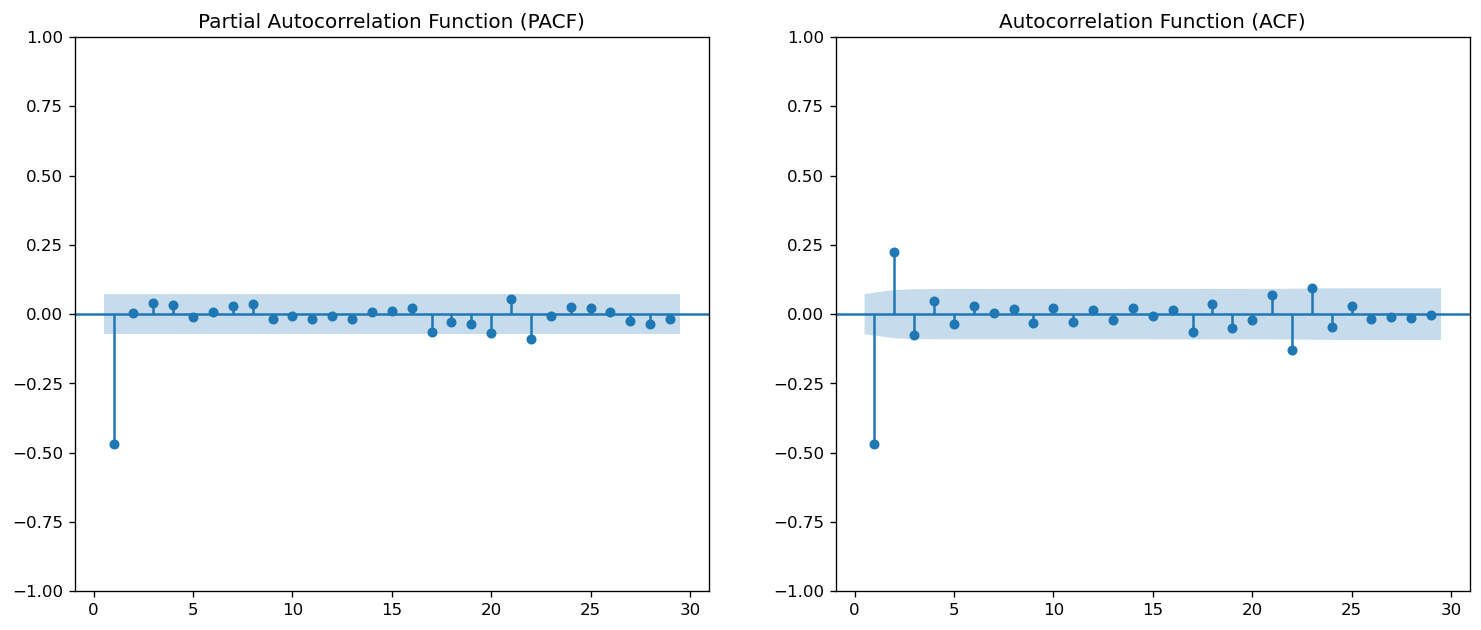

In [9]:
# Fixing the size for all plots
plt.rcParams.update({'figure.figsize': (15, 6), 'figure.dpi': 120})

# 1st Differencing to make stationary time series data
differenced_revenue = df.revenue.diff()

fig, axes = plt.subplots(1, 2)

plot_pacf(differenced_revenue.dropna(), ax=axes[0], zero=False)
axes[0].set_title('Partial Autocorrelation Function (PACF)')

plot_acf(differenced_revenue.dropna(), ax=axes[1], zero=False)
axes[1].set_title('Autocorrelation Function (ACF)')

plt.show()


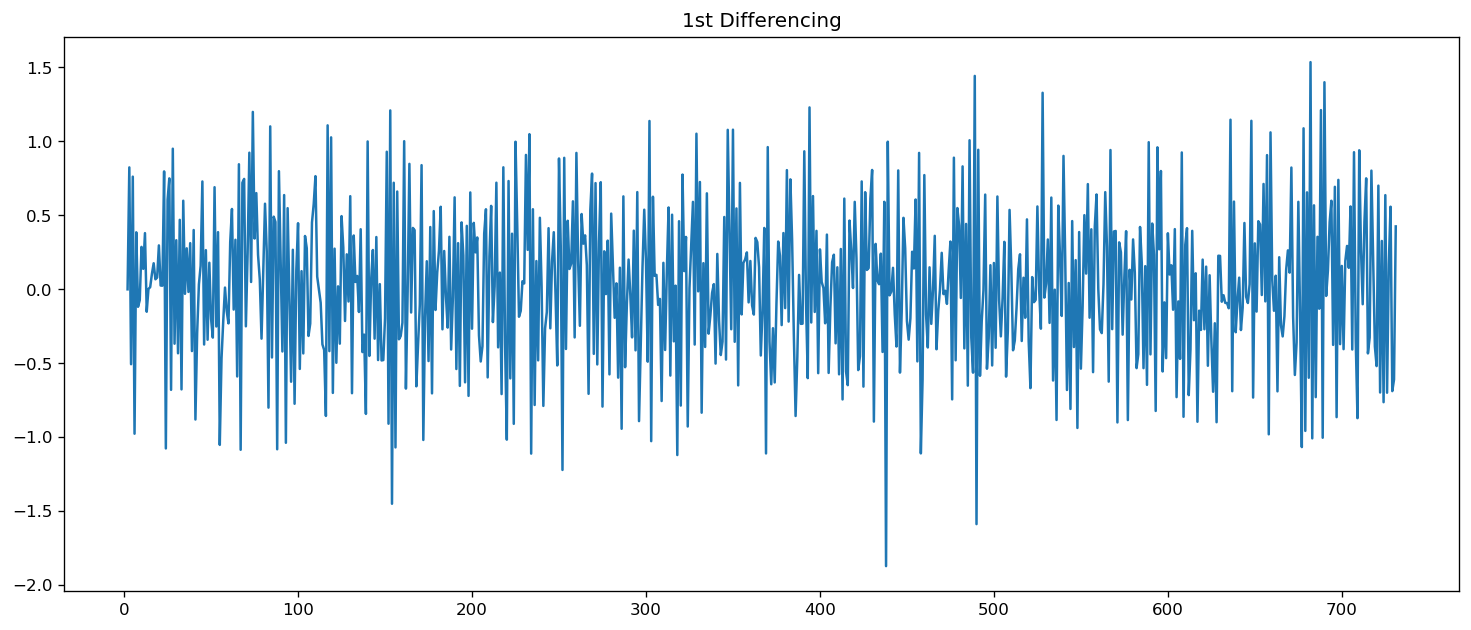

In [10]:
# plotting first differencing 
fig, ax = plt.subplots()
ax.plot(differenced_revenue)
ax.set_title('1st Differencing')
plt.show()

In [11]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(df.revenue.diff().dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -44.87452719387599
p-value: 0.0
Critical Values:
	1%: -3.4393520240470554
	5%: -2.8655128165959236
	10%: -2.5688855736949163


### (C3) Summary:

Null values were dropped during the differincing of the data. We also ran the ADF test again in order to verify that the data was stationary alongside visualizing it as well. We will now complete the data prep by changing the days to dates and splitting the data into testing and training sets. 

In [12]:
df.isnull().sum()

revenue    0
dtype: int64

In [13]:
# changing the date
df.index = pd.date_range(start='2019-01-01', periods=731, freq='D')

# splitting data into training and testing sets
split_date = '2020-08-08'  
train = df[df.index <= split_date]
test = df[df.index > split_date]

print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

#stationary data to csv
train.to_csv('train.csv')
test.to_csv('test.csv')

Training set shape: (586, 1)
Testing set shape: (145, 1)


### (C5) Decomposed Time Series:

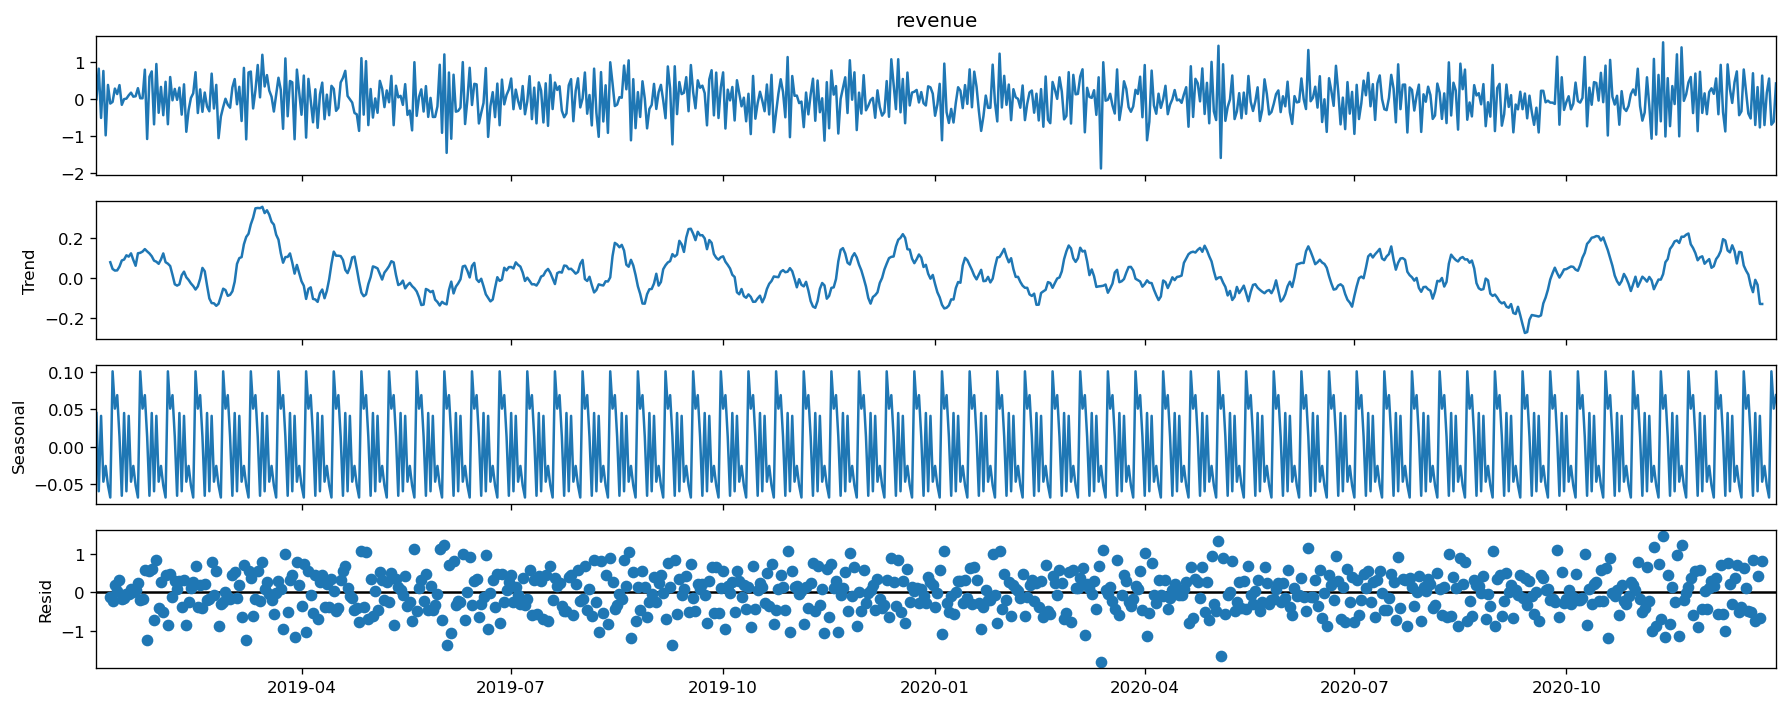

In [14]:
result = seasonal_decompose(df.revenue.diff().dropna(), model='additive', period=12)

# Plot Trend, Seasonality, Residuals
result.plot()
plt.show()

<Axes: title={'center': 'Seasonality'}>

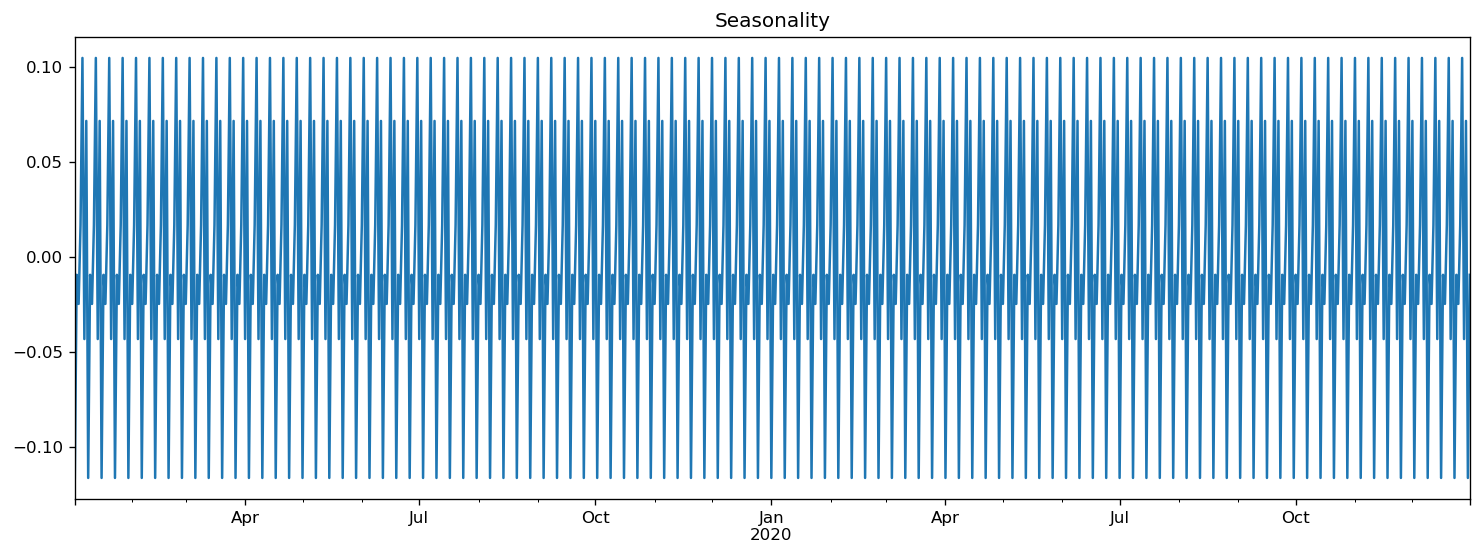

In [15]:
# Decomposing the data
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df.revenue.diff().dropna())
plt.figure(figsize = [15,5])
plt.title('Seasonality')
decomposed.seasonal.plot()

(17897.0, 17928.0)

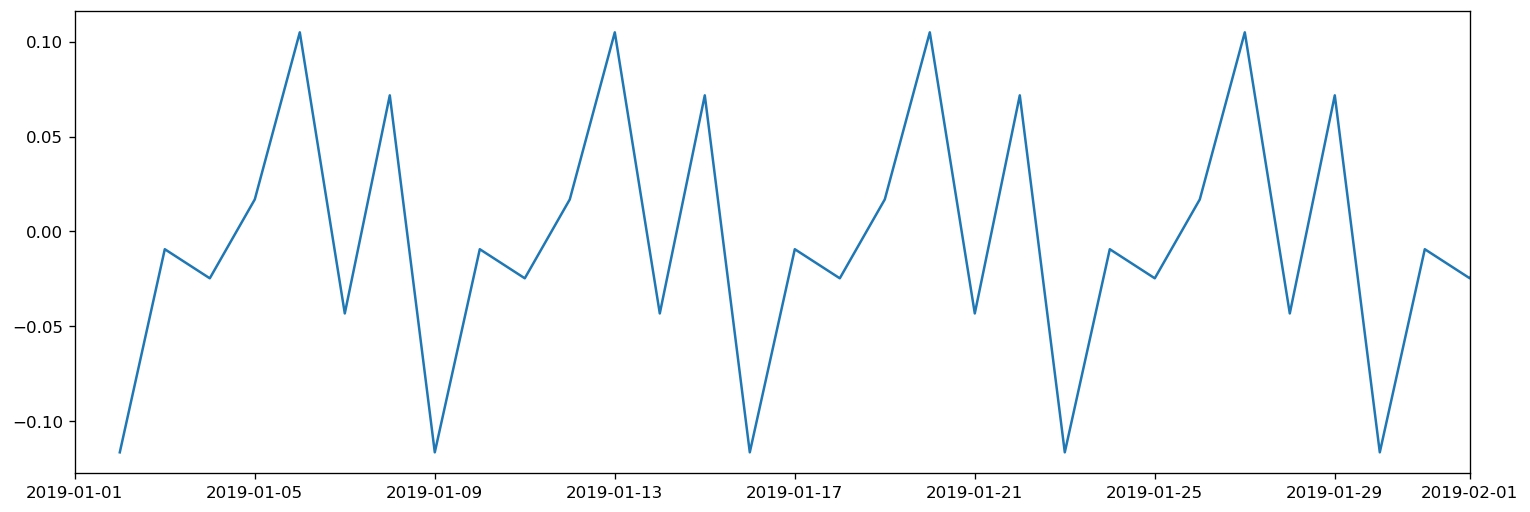

In [16]:
# Plot seasonal component of the data
plt.figure(figsize = [15,5])
plt.plot(decomposed.seasonal)
plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2019-02-01'))

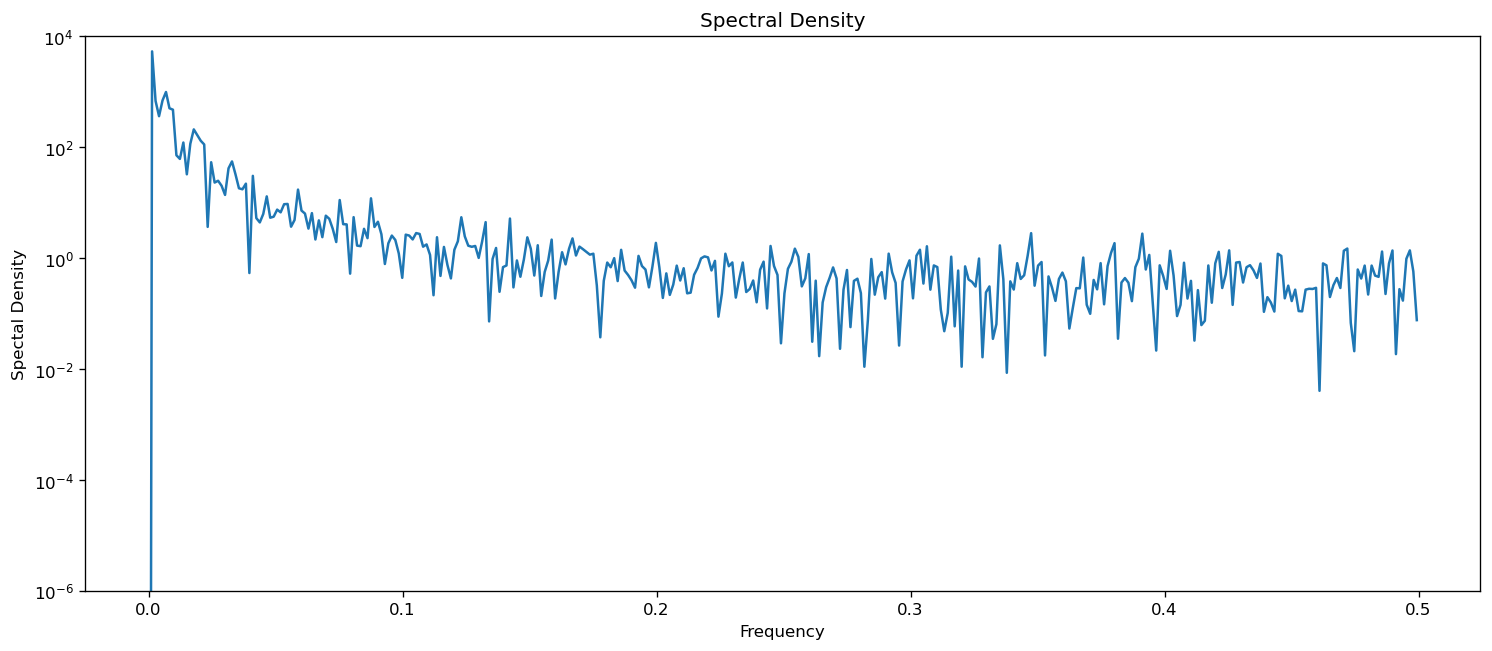

In [17]:
# Power spectral density
from scipy import signal
f, Pxx_den = signal.periodogram(df['revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e4])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

### Forecast results:

(D2) Arima Model:

As done above this data is best suited for an AR(1) model. For this model our order for (p,d,q) will be (1,0,0)

In [18]:
# import and ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Specify the order (p, d, q)
order = (1, 0, 0) 

# Create the ARIMA model
model = ARIMA(train, order=order)

# Fit the ARIMA model
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  586
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -456.964
Date:                Sat, 10 Feb 2024   AIC                            919.928
Time:                        18:09:17   BIC                            933.048
Sample:                    01-01-2019   HQIC                           925.041
                         - 08-08-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1328      2.158      3.769      0.000       3.904      12.362
ar.L1          0.9929      0.005    204.635      0.000       0.983       1.002
sigma2         0.2765      0.017     16.087      0.000       0.243       0.310
===================================================================================
Ljung-Box (L1) (Q):                 123.09   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               0.93   Skew:                            -0.12
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

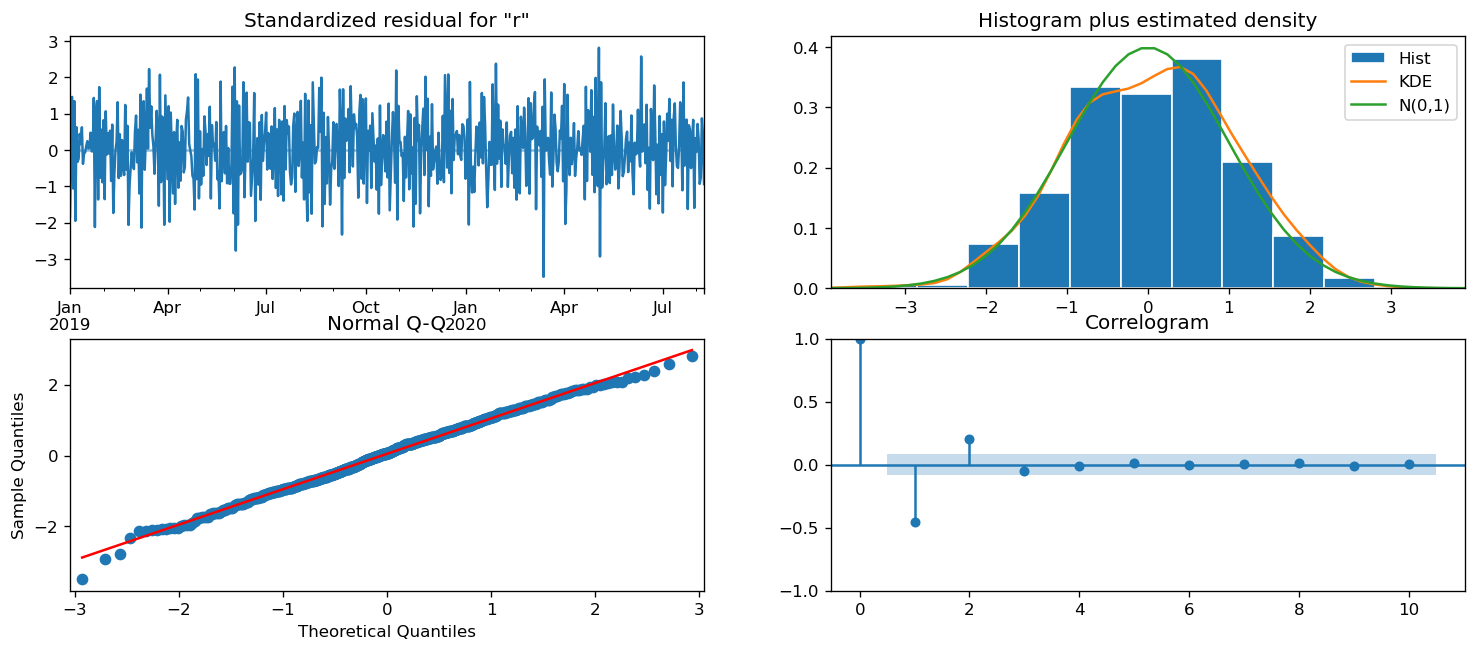

In [19]:
model_fit.plot_diagnostics(figsize=(15,6))
plt.show()

### Forecast D3:

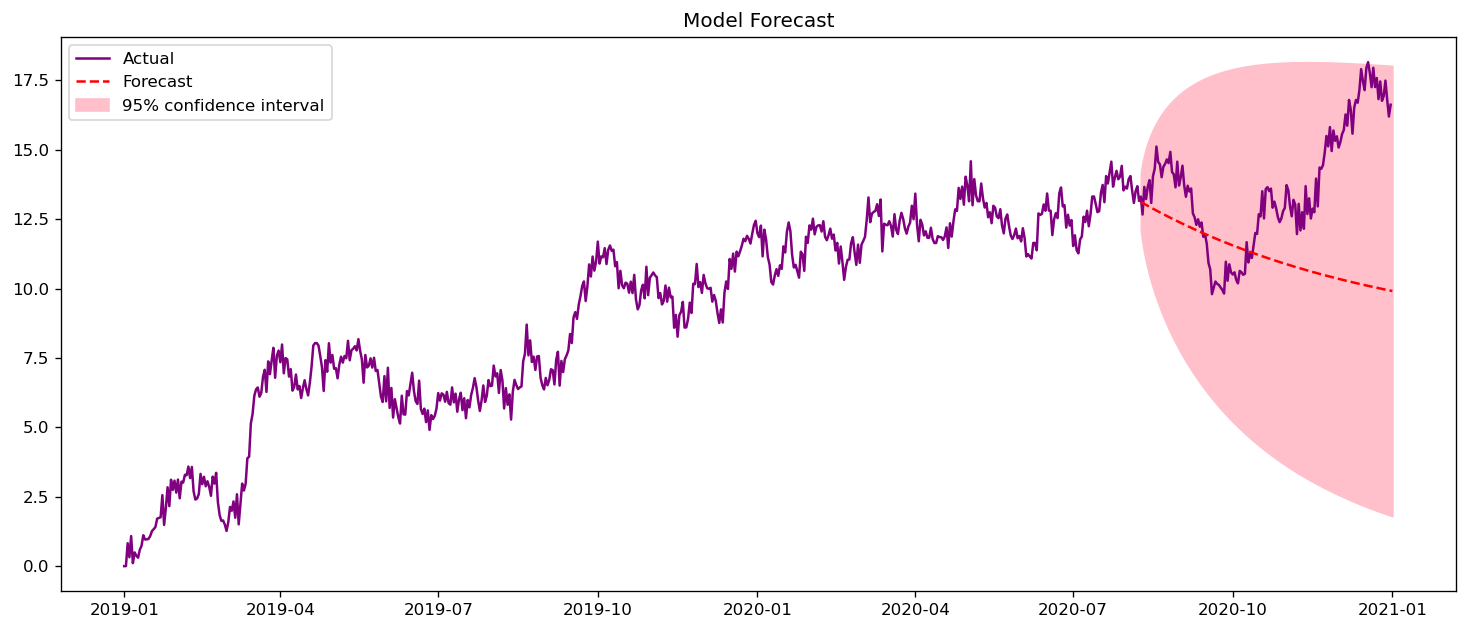

In [20]:
# Get forecast
forecast = model_fit.get_forecast(steps=146, dynamic=True)

#calculate confidence interval
conf_int = forecast.conf_int()

# Plot the forecasts
plt.plot(df, color='purple', label='Actual')
plt.plot(forecast.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(conf_int.index, conf_int['lower revenue'], conf_int['upper revenue'], color = 'pink', label='95% confidence interval')
plt.plot()
plt.legend()
plt.title('Model Forecast')
plt.show()

In [21]:
forecast.predicted_mean

2020-08-09    13.117319
2020-08-10    13.081986
2020-08-11    13.046904
2020-08-12    13.012071
2020-08-13    12.977485
                ...    
2020-12-28     9.960964
2020-12-29     9.948006
2020-12-30     9.935139
2020-12-31     9.922363
2021-01-01     9.909678
Freq: D, Name: predicted_mean, Length: 146, dtype: float64

In [22]:
forecast.conf_int()

,lower revenue,upper revenue
2020-08-09,12.086709,14.147928
2020-08-10,11.629641,14.534331
2020-08-11,11.274430,14.819379
2020-08-12,10.972601,15.051542
2020-08-13,10.705297,15.249672
...,...,...
2020-12-28,1.885261,18.036668
2020-12-29,1.863585,18.032426
2020-12-30,1.842134,18.028143
2020-12-31,1.820904,18.023822


In [23]:
# extracting the values from the dataframe
actual_values = df['revenue'].iloc[-146:].values 

# extracting the forecasted values
forecasted_values = forecast.predicted_mean.values

# calculate mse
rmse = mean_squared_error(actual_values, forecasted_values)

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 13.244061697992587


### Part V

(E1)

ARIMA Model: In order to identify the ARIMA model to use I first had to generate plots for autocorrelation, this was important to figure out wether the data was better suited for an autoregression model or a moving average model. Once I plotted both options I nooticed that the ACF model fell of at 2 while the PACF model cut off at 1, which led me to select the AR(1) model as a better fit. 

Prediction Interval: the prediction interval for the forecast is 146 steps, which represents 20% of the full dataset. 

Forecast Length Justification: The model had almost 2 years worth of data, I chose to utilize 20% of the data due to the confidence interval. The further removed we are from the historical data allows the predictions to increase and would jeporadize the models usefulness.

Evaluation Metric: The evaluation metric that I decided to chose was Root Mean Squared Error. This metric would allow the model to be easily compared to other models and the key goal for RMSE is that you aim for the error value to be as low as possible as that would indicate the mdoel is more accurate. Our models RMSE score would indicate that on avergae the models predictions deviate 13 units from the actual values. I have also used the plot diagnostics function in order to provide more details about the models performance.

### (E2) Visualization of Final Model:

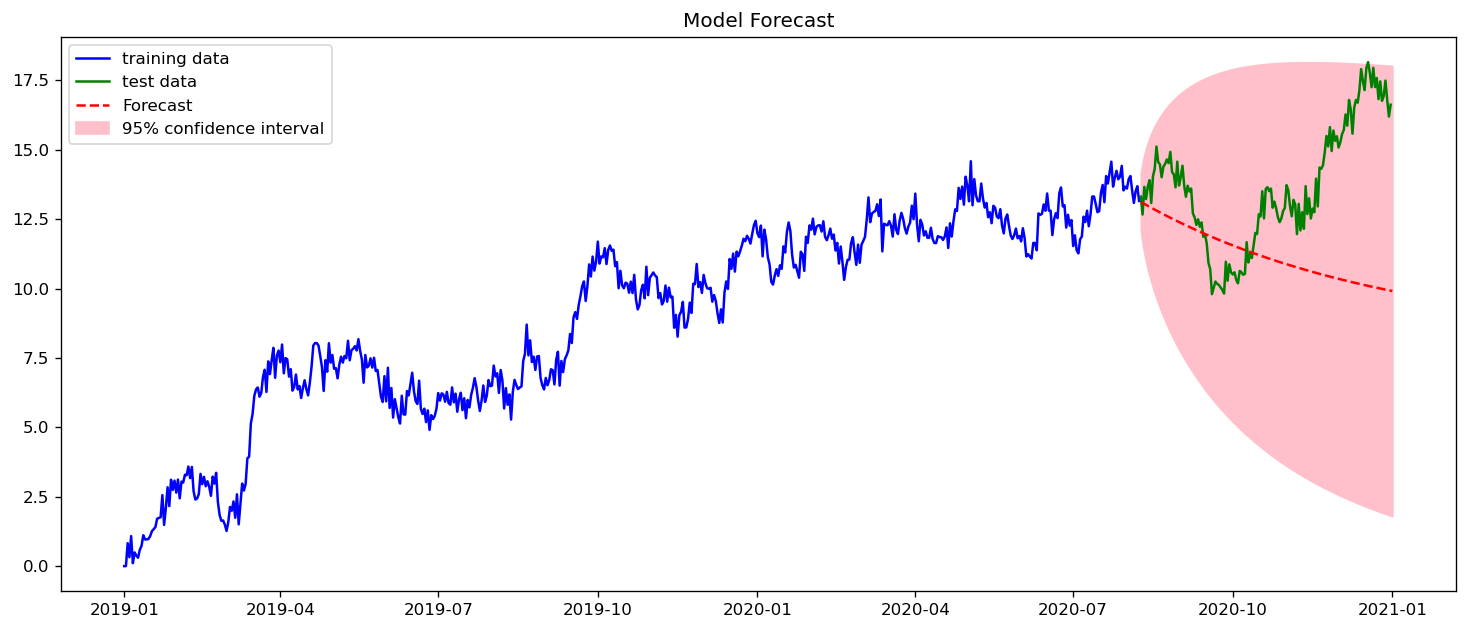

In [26]:
# Get forecasts
forecast = model_fit.get_forecast(steps=146, dynamic=True)

#calculate confidence interval
conf_int = forecast.conf_int()

# Plot the forecasts
plt.plot(train, color='blue', label='training data')
plt.plot(test, color='green', label='test data')
plt.plot(forecast.predicted_mean, color='red', label='Forecast', linestyle='dashed')
plt.fill_between(conf_int.index, conf_int['lower revenue'], conf_int['upper revenue'], color = 'pink', label='95% confidence interval')
plt.plot()
plt.legend()
plt.title('Model Forecast')
plt.show()

### (E3) Recommended Course of Action:

Based on the model the expected revenue numbers look to be decreasing, based on this I would recommend that a meeting be held with senior leadership in order to understand why we are expecting revenue to decrease. I would also try to compare our expected revenue to current revenue from some of our publicly traded competitors in order to see if we can take their published historical revenue numbers and use it to forecast their anticipated revenue in order to see if other companies are forecasting the same cash shortfall that our company is anticipating.



# Sources
Alam, B. (2022, June 6). Using the ARIMA model and Python for Time Series forecasting. Hands-On-Cloud. https://hands-on.cloud/using-the-arima-model-and-python-for-time-series-forecasting/

Python | ARIMA Model for Time Series Forecasting. (2020, February 7). GeeksforGeeks. https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: Principles and Practice. (2nd ed.) OTexts. https://otexts.org/fpp2/